# 네이버 감성분석 

테스트를 위해 LSTM 기반으로 모델을 작성했다.
이전과 차이점이 있다면, 나는 목표에 맞게 새로운 Tokenizer를 사용할 것이며, 사전 학습된 Word2Vec도 적용했다.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from konlpy.tag import Okt, Komoran
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

## 실험 1: 기존에 배운 방식으로 해결해보자


### 데이터 전처리

1. missing value
2. duplicated value
3. length distribution check

In [2]:
# 데이터 로드
orig_train = pd.read_table('nsmc/ratings_train.txt')
orig_test = pd.read_table('nsmc/ratings_test.txt')

# 두번째 실험을 위해 사용할 데이터 분리
train_data = orig_train.copy()
test_data = orig_test.copy()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 데이터 결측치 확인
null_check = pd.isnull(train_data['document'])
null_data = train_data.loc[null_check, 'document']
null_data.head()

25857     NaN
55737     NaN
110014    NaN
126782    NaN
140721    NaN
Name: document, dtype: object

In [4]:
train_data = train_data.dropna() # 결측치 제거
test_data = test_data.dropna() # 결측치 제거

In [5]:
# 중복값 확인
dupl_check = train_data.duplicated(subset=['document'])
dupl_data = train_data.loc[dupl_check, 'document']
dupl_data.head()

1058      4
1097     쵝오
1248     최고
1483     최고
1707    재밌다
Name: document, dtype: object

In [6]:
# 중복 제거
train_data = train_data.drop_duplicates(subset=['document'])

In [7]:
# 중복값 다시 확인
dupl_check = train_data.duplicated(subset=['document'])
dupl_data = train_data.loc[dupl_check, 'document']
dupl_data.head()

Series([], Name: document, dtype: object)

그럼 길이 분포는 어떨까?

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


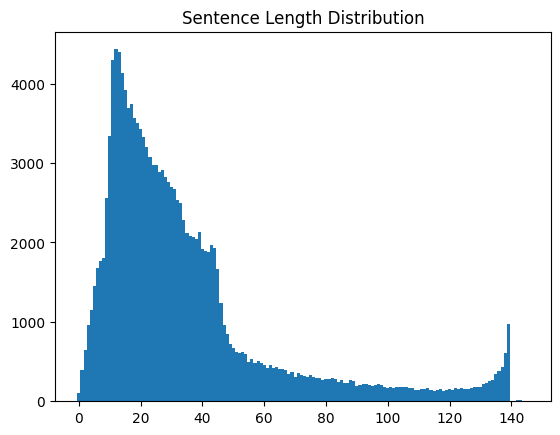

In [8]:
# 코퍼스 내 길이 분포 확인 

min_len = 999
max_len = 0
sum_len = 0

for sen in train_data.document:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [9]:
# 도대체 무슨 단어가 길이가 1인거지?
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


그렇게 유의미하지 않는 데이터로 보인다.

In [10]:
check_sentence_with_length(train_data['document'], 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
굿!
별루
씐나
쓰렉
볼만
허접
비추
좋다
ㅎㅎ
아나
ㅉㅉ
야.
역시
^^
오오
평이
지루
오욈
ㅋㅋ
지송
별로
눈물
당연
쩔어
별노
몰입
졸잼
돋네
오글
이응
첨봄
최악
잼씀
ok
유후
감동
gg
;;
조앙
1점
표절
명작
으휴
에효
ㄱ굿
굿잡
잼나
10
ㅜㅜ
우왕
거지
굿굿
좋음
실망
굿.
애이
짱임
전설
mm
와우
등록
하위
그닥
뭉클
삼류
HN
윤하
섹시
실화
머냐
수작
꿀잼
동감
dd
굳ㅋ
굳!
추천
좋아
55
안봐
개쩜
올레
난해
ㅠㅠ
뭐니
ㅁㅁ
뭥미
쓰랙
좇~
오우
미안


길이가 2인 단어는 '최고'와 같은 유의미한 단어도 있다.  
또한 페딩으로 길이를 100만 사용할 예정이기 때문에 그 이상이 되는 데이터를 제거한다.

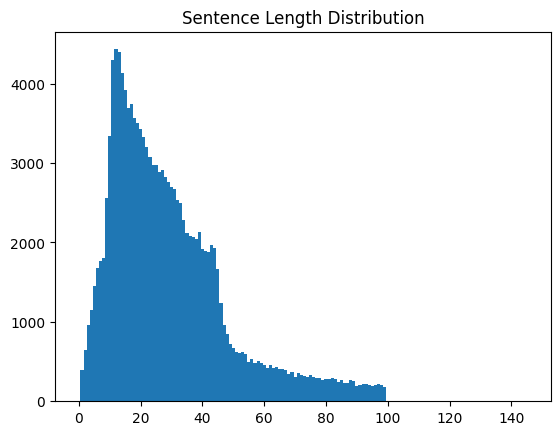

In [11]:
# 길이 조건에 맞는 문장만 선택합니다.
train_data = train_data[train_data['document'].str.len().between(2, 100)]


# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [12]:
check_sentence_with_length(train_data['document'], 1)

In [13]:
check_sentence_with_length(train_data['document'], 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
굿!
별루
씐나
쓰렉
볼만
허접
비추
좋다
ㅎㅎ
아나
ㅉㅉ
야.
역시
^^
오오
평이
지루
오욈
ㅋㅋ
지송
별로
눈물
당연
쩔어
별노
몰입
졸잼
돋네
오글
이응
첨봄
최악
잼씀
ok
유후
감동
gg
;;
조앙
1점
표절
명작
으휴
에효
ㄱ굿
굿잡
잼나
10
ㅜㅜ
우왕
거지
굿굿
좋음
실망
굿.
애이
짱임
전설
mm
와우
등록
하위
그닥
뭉클
삼류
HN
윤하
섹시
실화
머냐
수작
꿀잼
동감
dd
굳ㅋ
굳!
추천
좋아
55
안봐
개쩜
올레
난해
ㅠㅠ
뭐니
ㅁㅁ
뭥미
쓰랙
좇~
오우
미안


In [14]:
print('orig ', len(orig_train))
print('preprocessing ', len(train_data))

orig  150000
preprocessing  137397


약 20,000개의 불필요한 데이터가 감소했다.  
적당히 잘 전처리 되었다고 생각된다.

### Tokenizer

1. Word2vec
2. konlpy의 형태소 분석기 적용

In [15]:
# Okt 또는 Komoran 인스턴스 생성

# mor = Okt()
mor = Komoran() # 성능을 위해 Komoran 채택

# 텍스트데이터 토큰화
train_data['document'] = train_data['document'].apply(mor.morphs)
test_data['document'] = test_data['document'].apply(mor.morphs)

train_data.head()

,id,document,label
0,9976970,"[아, 더빙, ., ., 진짜, 짜증, 나, 네요, 목소리]",0
1,3819312,"[흠, ..., 포스터, 보고, 초딩, 영화, 줄, ...., 오버, 연기, 조차,...",1
2,10265843,[너무재밓었다그래서보는것을추천한다],0
3,9045019,"[교도소, 이야기, 이, 구먼, .., 솔직히, 재미, 는, 없, 다, ., ., ...",0
4,6483659,"[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, !, 스...",1


In [16]:
# 텍스트 데이터를 숫자로 변환
tokenizer = Tokenizer()

#fit_on_texts (https://www.dinolabs.ai/186)
# train 데이터에 맞게 한번만 학습하면 됨
tokenizer.fit_on_texts(train_data['document'])

train_sequences = tokenizer.texts_to_sequences(train_data['document'])
test_sequences = tokenizer.texts_to_sequences(test_data['document'])

# 패딩 처리
train_inputs = pad_sequences(train_sequences, maxlen=100)
test_inputs = pad_sequences(test_sequences, maxlen=100)

# 레이블 데이터를 numpy array로 변환
train_labels = np.array(train_data['label'])
test_labels = np.array(test_data['label'])


### 사전 학습된 Word2Vec 적용

In [17]:
# 사전 학습된 Word2Vec 모델 로드
word2vec = Word2Vec.load('ko/ko.bin') # 'word2vec_model_path'를 실제 모델 경로로 변경

# 임베딩 레이어의 가중치를 초기화
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_50962/3388869597.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec:
/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_50962/3388869597.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[word]


### 모델 학습

In [18]:
# 모델 정의
model1 = Sequential()
model1.add(Embedding(
    len(tokenizer.word_index)+1, 
    word2vec.vector_size, 
    weights=[embedding_matrix], 
    trainable=True # 파인튜닝 허용
))
model1.add(LSTM(128))
model1.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc1 = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history1 = model1.fit(train_inputs, train_labels, epochs=15, callbacks=[es1, mc1], batch_size=60, validation_split=0.2)


2023-06-26 01:33:56.880217: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-06-26 01:33:56.880242: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-06-26 01:33:56.880245: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-06-26 01:33:56.880277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-26 01:33:56.880294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2023-06-26 01:33:59.462518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 01:33:59.641924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 01:33:59.828002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1832/1832 [==============================] - ETA: 0s - loss: 0.3961 - accuracy: 0.8167

2023-06-26 01:36:14.435534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 01:36:14.502400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1832/1832 [==============================] - 141s 76ms/step - loss: 0.3961 - accuracy: 0.8167 - val_loss: 0.3360 - val_accuracy: 0.8520
Epoch 2/15
1832/1832 [==============================] - 136s 74ms/step - loss: 0.2722 - accuracy: 0.8904 - val_loss: 0.3298 - val_accuracy: 0.8584
Epoch 3/15
1832/1832 [==============================] - 136s 74ms/step - loss: 0.1975 - accuracy: 0.9231 - val_loss: 0.3553 - val_accuracy: 0.8560
Epoch 4/15
1832/1832 [==============================] - 136s 74ms/step - loss: 0.1442 - accuracy: 0.9455 - val_loss: 0.3898 - val_accuracy: 0.8516
Epoch 5/15
1832/1832 [==============================] - 136s 74ms/step - loss: 0.1047 - accuracy: 0.9625 - val_loss: 0.4425 - val_accuracy: 0.8432
Epoch 6/15
1832/1832 [==============================] - 135s 73ms/step - loss: 0.0730 - accuracy: 0.9746 - val_loss: 0.5156 - val_accuracy: 0.8454
Epoch 6: early stopping


In [19]:
# 모델 평가
print(model1.evaluate(test_inputs, test_labels))


2023-06-26 01:47:39.099762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 01:47:39.200474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 18s 11ms/step - loss: 0.5157 - accuracy: 0.8468
[0.5156794786453247, 0.8467708230018616]


## 평가 기록

| 방법 | Loss | Accuracy |
|------|------|----------|
| Okt 사용 전 | 0.7988 | 0.8033 |
| Okt 사용 후 | 0.6932 | 0.4965 |
| 깜빡한 정수화 학습 및 Komoran 사용 | 0.5018 | 0.8387 |
| 사전 학습된 Word2Vec 임베딩 적용 | 0.4065 | 0.8304 |
| Word2Vec에 파인 튜닝 허용 | 0.4980 | 0.8473 |



이 과정을 통해 Base Model에서 약 4%의 성능을 개선함.

## 실험 2: SentencePiece를 이용해보자

In [20]:
# 데이터 준비
train_data = orig_train.copy()
test_data = orig_test.copy()

# 대충 위에서 이미 결측치를 확인 했기 때문에 그대로 진행
# 결측치
train_data = train_data.dropna()
test_data = test_data.dropna()

# 중복 제거
train_data = train_data.drop_duplicates(subset=['document'])

# 길이 조건에 맞는 문장만 선택합니다.
train_data = train_data[train_data['document'].str.len().between(2, 100)]

print('done')

done


### Tokenizer 적용: sentencepiece

노드의 설명이 이해가 않가서 다른 글 참고함
https://lsjsj92.tistory.com/600


기본 model은 unigram이라고 함 https://choice-life.tistory.com/12



In [21]:
import tensorflow as tf
import sentencepiece as spm

with open('nsmc_text.txt', 'w', encoding='utf-8') as f:
    for line in train_data['document'].values:
        f.write(line + '\n')

input_fime = 'nsmc_text.txt'
vocab_size = 8000
prefix = 'korean_spm'

templates = '--input={} --model_prefix={} --vocab_size={}'
cmd = templates.format(input_fime, prefix, vocab_size)

spm.SentencePieceTrainer.Train(cmd)


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=nsmc_text.txt --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_text.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>

In [22]:
# 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(prefix))

for t in train_data.document.values[:5]:
    print(t)
    print(sp.EncodeAsPieces(t))
    print(sp.EncodeAsIds(t))
    print()


아 더빙.. 진짜 짜증나네요 목소리
['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
[59, 873, 5, 33, 1911, 64, 1836]

흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
['▁흠', '...', '포스터', '보고', '▁초딩', '영화', '줄', '....', '오', '버', '연기', '조차', '▁가볍지', '▁않', '구나']
[1557, 8, 4448, 155, 1312, 30, 259, 48, 176, 494, 336, 1458, 6249, 425, 411]

너무재밓었다그래서보는것을추천한다
['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다']
[23, 392, 7705, 391, 3817, 452, 1956, 1461, 309]

교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
['▁교', '도', '소', '▁이야기', '구먼', '▁', '..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
[2002, 12, 207, 226, 6017, 3, 5, 4758, 1139, 111, 5, 665, 263, 125]

사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
['▁사이', '몬', '페', '그', '의', '▁', '익', '살', '스런', '▁연기가', '▁돋보', '였던', '▁영화', '!', '스파이더맨', '에서', '▁늙어', '보이', '기만', '▁했던', '▁커', '스', '틴', '▁', '던', '스트', '가', '▁너무나도', '▁', '이뻐', '보', '였다']
[2685, 2421, 2690, 188, 10, 3, 1300, 342, 2203, 477, 2260, 1753, 7, 22, 5552, 50, 6351, 2786, 1262, 3218, 3303, 62, 2180, 3, 112

In [23]:
# 텍스트 데이터 토큰화
train_data['document'] = train_data['document'].apply(sp.EncodeAsPieces)
test_data['document'] = test_data['document'].apply(sp.EncodeAsPieces)

### 정수화 및 시퀀스 구성

In [24]:
# 토큰화된 데이터를 숫자로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['document'])

train_sequences = tokenizer.texts_to_sequences(train_data['document'])
test_sequences = tokenizer.texts_to_sequences(test_data['document'])

# 패딩 처리
train_inputs = pad_sequences(train_sequences, maxlen=100)
test_inputs = pad_sequences(test_sequences, maxlen=100)

# 레이블 데이터를 numpy array로 변환
train_labels = np.array(train_data['label'])
test_labels = np.array(test_data['label'])

#### 여기서 잠깐, 왜 굳이 EncodeAsIds를 않쓰고 EncodeAsPieces 후에 fit_on_texts를 사용했나요??

EncodeAsPieces 후에 fit_on_texts를 사용하는 방법은 두 단계의 토큰화 과정을 거치므로, 더 세밀한 토큰화가 가능할 수 있다.  
하지만 이는 추가적인 계산을 필요로 하며, 두 단계의 토큰화 과정이 항상 더 좋은 결과를 보장하는 것은 아니다.   
반면, EncodeAsIds를 사용하는 방법은 한 단계의 토큰화 과정만을 거치므로, 계산 효율성이 더 좋을 수 있다.  




나는 성능과 시간이 충분하다고 보고, 세밀하게 할 수 있다는 전자의 방법을 사용했다.  
또한 과제를 수행하는 과정에서 적은 코드 수정으로 이용할 수 있다는 장점 또한 존재한다.  
두 방법에 대한 의견은 사람마다 다르겠지만, 내가 이 방식을 사용한 이유는 이런 이유로 사용했다.

### Word2Vec 적용

In [25]:
# 사전 학습된 Word2Vec 모델 로드
word2vec = Word2Vec.load('ko/ko.bin')

# 임베딩 레이어의 가중치를 초기화
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_50962/2893645305.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec:
/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_50962/2893645305.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[word]


### 동일 구성의 두번째 모델 구성 및 학습

In [26]:
# 모델 정의
model2 = Sequential()
model2.add(Embedding(
    len(tokenizer.word_index)+1, 
    word2vec.vector_size, 
    weights=[embedding_matrix], 
    trainable=True # 파인튜닝 허용
))
model2.add(LSTM(128))
model2.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc2 = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history2 = model2.fit(train_inputs, train_labels, epochs=15, callbacks=[es2, mc2], batch_size=60, validation_split=0.2)


Epoch 1/15


2023-06-26 01:48:14.841471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 01:48:15.031509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 01:48:15.239727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1832/1832 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.8133

2023-06-26 01:50:19.677851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 01:50:19.750296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1832/1832 [==============================] - 131s 71ms/step - loss: 0.4016 - accuracy: 0.8133 - val_loss: 0.3350 - val_accuracy: 0.8536
Epoch 2/15
1832/1832 [==============================] - 126s 69ms/step - loss: 0.2999 - accuracy: 0.8707 - val_loss: 0.3251 - val_accuracy: 0.8563
Epoch 3/15
1832/1832 [==============================] - 126s 69ms/step - loss: 0.2541 - accuracy: 0.8931 - val_loss: 0.3272 - val_accuracy: 0.8600
Epoch 4/15
1832/1832 [==============================] - 126s 69ms/step - loss: 0.2007 - accuracy: 0.9176 - val_loss: 0.3693 - val_accuracy: 0.8557
Epoch 5/15
1832/1832 [==============================] - 125s 68ms/step - loss: 0.1405 - accuracy: 0.9447 - val_loss: 0.4460 - val_accuracy: 0.8530
Epoch 6/15
1832/1832 [==============================] - 125s 68ms/step - loss: 0.0881 - accuracy: 0.9679 - val_loss: 0.5575 - val_accuracy: 0.8455
Epoch 6: early stopping


In [27]:
# 모델 평가
print(model2.evaluate(test_inputs, test_labels))


2023-06-26 02:00:52.796088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 02:00:52.876637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 18s 11ms/step - loss: 0.5792 - accuracy: 0.8459
[0.5791632533073425, 0.8458907604217529]


## 시각화를 통해 구체적인 비교

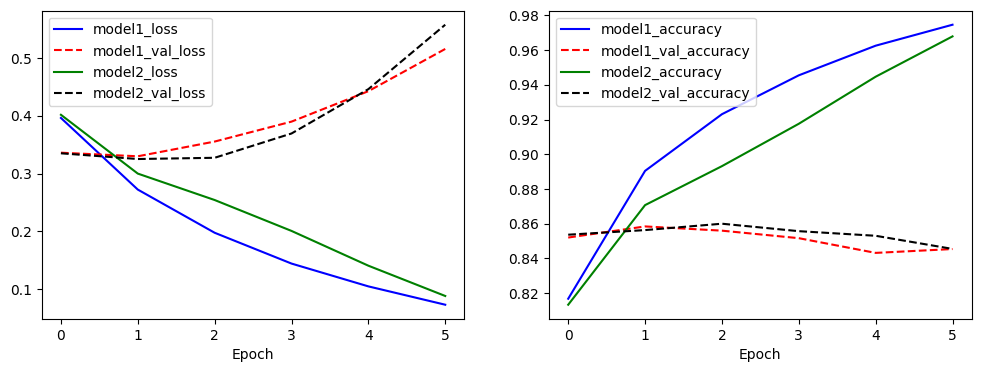

In [28]:
# 손실 함수 값 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], 'b-', label='model1_loss')
plt.plot(history1.history['val_loss'], 'r--', label='model1_val_loss')
plt.plot(history2.history['loss'], 'g-', label='model2_loss')
plt.plot(history2.history['val_loss'], 'k--', label='model2_val_loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], 'b-', label='model1_accuracy')
plt.plot(history1.history['val_accuracy'], 'r--', label='model1_val_accuracy')
plt.plot(history2.history['accuracy'], 'g-', label='model2_accuracy')
plt.plot(history2.history['val_accuracy'], 'k--', label='model2_val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


## 실험3: SentencePiece의 모드를 BPE로 바꿔보자

결과가 마음에 안든다.

BPE를 적용해보자.

### 데이터 전처리 대충...

In [29]:
# 데이터 준비
train_data = orig_train.copy()
test_data = orig_test.copy()

# 대충 위에서 이미 결측치를 확인 했기 때문에 그대로 진행
# 결측치
train_data = train_data.dropna()
test_data = test_data.dropna()

# 중복 제거
train_data = train_data.drop_duplicates(subset=['document'])

# 길이 조건에 맞는 문장만 선택합니다.
train_data = train_data[train_data['document'].str.len().between(2, 100)]

In [30]:
with open('nsmc_text_bpe.txt', 'w', encoding='utf-8') as f:
    for line in train_data['document'].values:
        f.write(line + '\n')

input_fime = 'nsmc_text_bpe.txt'
vocab_size = 8000
prefix = 'korean_spm_bpe'

templates = '--input={} --model_prefix={} --vocab_size={} --model_type=bpe'
cmd = templates.format(input_fime, prefix, vocab_size)

spm.SentencePieceTrainer.Train(cmd)


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=nsmc_text_bpe.txt --model_prefix=korean_spm_bpe --vocab_size=8000 --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: nsmc_text_bpe.txt
  input_format: 
  model_prefix: korean_spm_bpe
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_

In [31]:
# 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format(prefix))

for t in train_data.document.values[:5]:
    print(t)
    print(sp.EncodeAsPieces(t))
    print(sp.EncodeAsIds(t))
    print()


아 더빙.. 진짜 짜증나네요 목소리
['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
[8, 1065, 3, 51, 2133, 34, 2107]

흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
['▁흠', '...', '포스터', '보고', '▁초딩', '영화', '줄', '....', '오', '버', '연기', '조차', '▁가볍', '지', '▁않', '구나']
[1453, 7, 4502, 159, 1200, 4, 6488, 21, 6347, 6460, 257, 1854, 1791, 6280, 70, 395]

너무재밓었다그래서보는것을추천한다
['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다']
[24, 6303, 7826, 113, 3838, 423, 1401, 1658, 280]

교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
['▁교', '도', '소', '▁이야기', '구', '먼', '▁..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
[644, 6283, 6377, 275, 6372, 6768, 404, 4839, 1287, 215, 3, 1007, 131, 6314]

사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
['▁사이', '몬', '페', '그', '의', '▁익', '살', '스런', '▁연기가', '▁돋보', '였던', '▁영화', '!', '스', '파이', '더맨', '에서', '▁늙', '어', '보이', '기만', '▁했던', '▁커', '스', '틴', '▁던', '스트', '가', '▁너무나도', '▁이뻐', '보', '였다']
[2746, 7123, 6876, 6307, 6293, 3183, 6504, 1887, 635, 1520, 2152, 5, 6294, 6311, 1710, 5487, 52, 2313, 6291

In [32]:
# 텍스트 데이터 토큰화
train_data['document'] = train_data['document'].apply(sp.EncodeAsPieces)
test_data['document'] = test_data['document'].apply(sp.EncodeAsPieces)

In [33]:
# 토큰화된 데이터를 숫자로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['document'])

train_sequences = tokenizer.texts_to_sequences(train_data['document'])
test_sequences = tokenizer.texts_to_sequences(test_data['document'])

# 패딩 처리
train_inputs = pad_sequences(train_sequences, maxlen=100)
test_inputs = pad_sequences(test_sequences, maxlen=100)

# 레이블 데이터를 numpy array로 변환
train_labels = np.array(train_data['label'])
test_labels = np.array(test_data['label'])

In [34]:
# 사전 학습된 Word2Vec 모델 로드
word2vec = Word2Vec.load('ko/ko.bin')

# 임베딩 레이어의 가중치를 초기화
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, word2vec.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_50962/2893645305.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec:
/var/folders/mg/rbbjnp_x0k31bv6dy862v00w0000gn/T/ipykernel_50962/2893645305.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[word]


### 모델 구성 및 학습

In [35]:
# 모델 정의
model3 = Sequential()
model3.add(Embedding(
    len(tokenizer.word_index)+1, 
    word2vec.vector_size, 
    weights=[embedding_matrix], 
    trainable=True # 파인튜닝 허용
))
model3.add(LSTM(128))
model3.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc3 = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history3 = model3.fit(train_inputs, train_labels, epochs=15, callbacks=[es3, mc3], batch_size=60, validation_split=0.2)


Epoch 1/15
1832/1832 [==============================] - 132s 71ms/step - loss: 0.4023 - accuracy: 0.8124 - val_loss: 0.3411 - val_accuracy: 0.8524
Epoch 2/15
1832/1832 [==============================] - 128s 70ms/step - loss: 0.3001 - accuracy: 0.8696 - val_loss: 0.3236 - val_accuracy: 0.8595
Epoch 3/15
1832/1832 [==============================] - 128s 70ms/step - loss: 0.2531 - accuracy: 0.8932 - val_loss: 0.3374 - val_accuracy: 0.8552
Epoch 4/15
1832/1832 [==============================] - 127s 69ms/step - loss: 0.2011 - accuracy: 0.9168 - val_loss: 0.3671 - val_accuracy: 0.8519
Epoch 5/15
1832/1832 [==============================] - 128s 70ms/step - loss: 0.1430 - accuracy: 0.9434 - val_loss: 0.4333 - val_accuracy: 0.8470
Epoch 6/15
1832/1832 [==============================] - 126s 69ms/step - loss: 0.0858 - accuracy: 0.9686 - val_loss: 0.5462 - val_accuracy: 0.8422
Epoch 6: early stopping


In [36]:
# 모델 평가
print(model3.evaluate(test_inputs, test_labels))


1563/1563 [==============================] - 18s 11ms/step - loss: 0.5529 - accuracy: 0.8393
[0.5528690218925476, 0.8393303751945496]


### 시각화

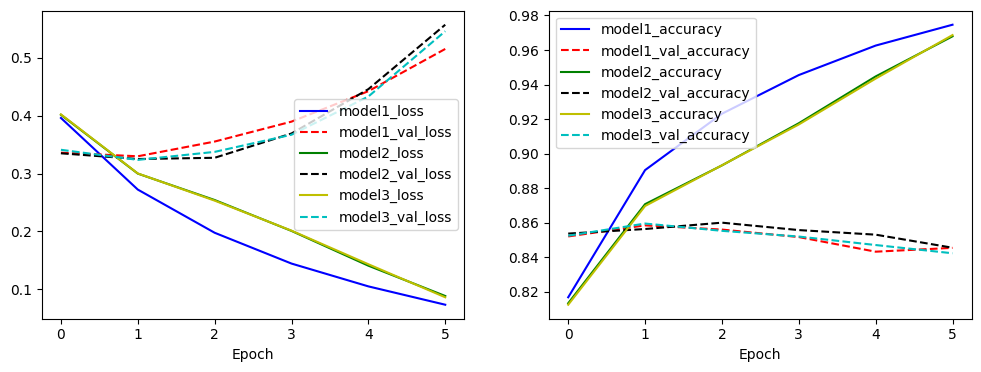

In [37]:
# 손실 함수 값 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], 'b-', label='model1_loss')
plt.plot(history1.history['val_loss'], 'r--', label='model1_val_loss')
plt.plot(history2.history['loss'], 'g-', label='model2_loss')
plt.plot(history2.history['val_loss'], 'k--', label='model2_val_loss')
plt.plot(history3.history['loss'], 'y-', label='model3_loss')
plt.plot(history3.history['val_loss'], 'c--', label='model3_val_loss')
plt.xlabel('Epoch')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], 'b-', label='model1_accuracy')
plt.plot(history1.history['val_accuracy'], 'r--', label='model1_val_accuracy')
plt.plot(history2.history['accuracy'], 'g-', label='model2_accuracy')
plt.plot(history2.history['val_accuracy'], 'k--', label='model2_val_accuracy')
plt.plot(history3.history['accuracy'], 'y-', label='model3_accuracy')
plt.plot(history3.history['val_accuracy'], 'c--', label='model3_val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


## 결론

가장 먼저 SentencePiece 사용시 기반 모델로 작성한 첫번째 모델보다 좋은 성적을 보여주지 못했다.  
그리고 SentencePiece 모델을 사용한 모델2와 모델3를 비교했을 때, 큰 차이는 보이지 않지만, BPE를 사용했을 때, 유니그램 대비 좀 더 좋은 성과를 보여준다.  
하지만, 평가 수치로 봤을 때, 형태소 분석기와 사전 처리된 Word2Vec 모델을 사용한 모델1이 가장 좋은 성과를 보여준다.  

다만, 토크나이징 전에 데이터를 좀 더 정제하고, 불용어를 제거하면 성능이 더 좋아질 것으로 보인다.

